# Test Segregation Score

This notebooks test the secregation score used to classify degree of mixing between PA and SA using synthetic datasets. Index adapted from [Dogsa & Mandic-Mulec, 2023](https://doi.org/10.1016/j.bioflm.2023.100157).

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Colormap 
n_species = 2
cmap = plt.get_cmap('Spectral',n_species)  # You can choose any colormap, e.g., 'plasma', 'jet', 'coolwarm', etc.
colors = cmap(np.linspace(0, 1, n_species)) 


def _create_chessboard(nx, ny, ds):
    """Create centered chessboard pattern with square size ds."""
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    xx, yy = np.meshgrid(x, y, indexing='ij')
    return ((xx // ds) + (yy // ds)) % 2

def _create_chessboard_points(nx, ny, ds, noise=0.3):
    """
    Create centered chessboard pattern as point data with noise.
    
    Parameters:
    -----------
    nx, ny : int
        Grid dimensions
    ds : int
        Square size for chessboard pattern
    noise : float
        Amount of noise to add to coordinates (default 0.3)
        
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with columns x, y, Type
    """
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    # Add noise to coordinates
    xx_noise = xx + np.random.uniform(-noise/2, noise/2, size=xx.shape)
    yy_noise = yy + np.random.uniform(-noise/2, noise/2, size=yy.shape)
    
    # Calculate pattern type
    pattern = ((xx // ds) + (yy // ds)) % 2
    
    # Flatten and create DataFrame
    df = pd.DataFrame({
        'x': xx_noise.flatten(),
        'y': yy_noise.flatten(),
        'Type': pattern.flatten().astype(int)
    })
    
    return df


def calc_segregation_scores(im, window_sizes):
    '''
    Calculate segregation scores for focal species in image im over specified window sizes.
    
    Parameters:
    -----------
    im : np.ndarray
        2D array with species labels
    window_sizes : list of int
        List of window sizes for calculating segregation scores  
    Returns:
    --------
    mean_segregation : np.ndarray
        Mean segregation scores for each window size
    std_segregation : np.ndarray
        Standard deviation of segregation scores for each window size
    
    '''

    focal_type = 1 # Define index of focal species type
    other_type = 0 # Define index of non-focal species type

    # Calculate global frequency of focal species
    N_focal_G = np.sum(im == focal_type)
    N_other_G = np.sum(im == other_type)

    # Loop over all cells to calculate segregation scores
    nx, ny = im.shape
    segregation_scores = []
    for i in range(nx):
        for j in range(ny):
            if im[i,j] == focal_type:
                segregation_cell = np.empty(len(window_sizes))
                for idx, window_size in enumerate(window_sizes):
                    x0 = max(0, i - window_size)
                    x1 = min(nx, i + window_size + 1)
                    y0 = max(0, j - window_size)
                    y1 = min(ny, j + window_size + 1)

                    # calculate segregation score of focal cell
                    local_window = im[x0:x1, y0:y1]
                    N_focal_L = np.sum(local_window == focal_type) 
                    N_other_L  = np.sum(local_window == other_type)

                    if N_focal_L == 0 and N_other_L == 0:
                        seg_cell = np.nan
                    else:
                        seg_cell = (N_focal_L/N_focal_G - N_other_L/N_other_G) / (N_focal_L/N_focal_G + N_other_L/N_other_G)

                    # calculate segregation score of focal cell
                    segregation_cell[idx] = seg_cell

                segregation_scores.append(segregation_cell)

    # Compute mean and std of segregation scores
    segregation_scores = np.array(segregation_scores)
    mean_segregation = np.mean(segregation_scores, axis=0)
    std_segregation = np.std(segregation_scores, axis=0)

    return (mean_segregation, std_segregation)



def calc_segregation_scores_points(df, window_sizes, focal_type=1, other_type=0):
    '''
    Calculate segregation scores for focal species using point data over specified window sizes.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with point data including species labels
        requires columns 'x', 'y', 'Type'
    window_sizes : list of int
        List of window sizes for calculating segregation scores  
    focal_type : int/ str
        Label of focal species type (default 1)
    other_type : int / str
        Label of non-focal species type (default 0)
    Returns:
    --------
    mean_segregation : np.ndarray
        Mean segregation scores for each window size
    std_segregation : np.ndarray
        Standard deviation of segregation scores for each window size
    
    '''

    x_cors = df['x'].values
    y_cors = df['y'].values
    types = df['Type'].values

    # Calculate global frequency of focal species
    N_focal_G = np.sum(types == focal_type)
    N_other_G = np.sum(types == other_type)

    segregation_scores = []
    for idx, row in df.iterrows():
        if row['Type'] == focal_type:

            # calculate distances from focal cell to all other cells
            dist = np.sqrt((x_cors - row['x'])**2 + (y_cors - row['y'])**2)
            segregation_cell = np.empty(len(window_sizes))
            
            #calculate segregation scores for each window size
            for idx, window_size in enumerate(window_sizes):

                neighbors = (dist > 0) & (dist <= window_size)
                N_focal_L = np.sum(types[neighbors] == focal_type)
                N_other_L = np.sum(types[neighbors] == other_type)  

                if N_focal_L == 0 and N_other_L == 0:
                    segregation_cell[idx] = np.nan
                else:
                    segregation_cell[idx] = (N_focal_L/N_focal_G - N_other_L/N_other_G) / (N_focal_L/N_focal_G + N_other_L/N_other_G)

                segregation_scores.append(segregation_cell)

    # Compute mean and std of segregation scores
    segregation_scores = np.array(segregation_scores)
    mean_segregation = np.mean(segregation_scores, axis=0)
    std_segregation = np.std(segregation_scores, axis=0)

    return (mean_segregation, std_segregation)

## Area based measure

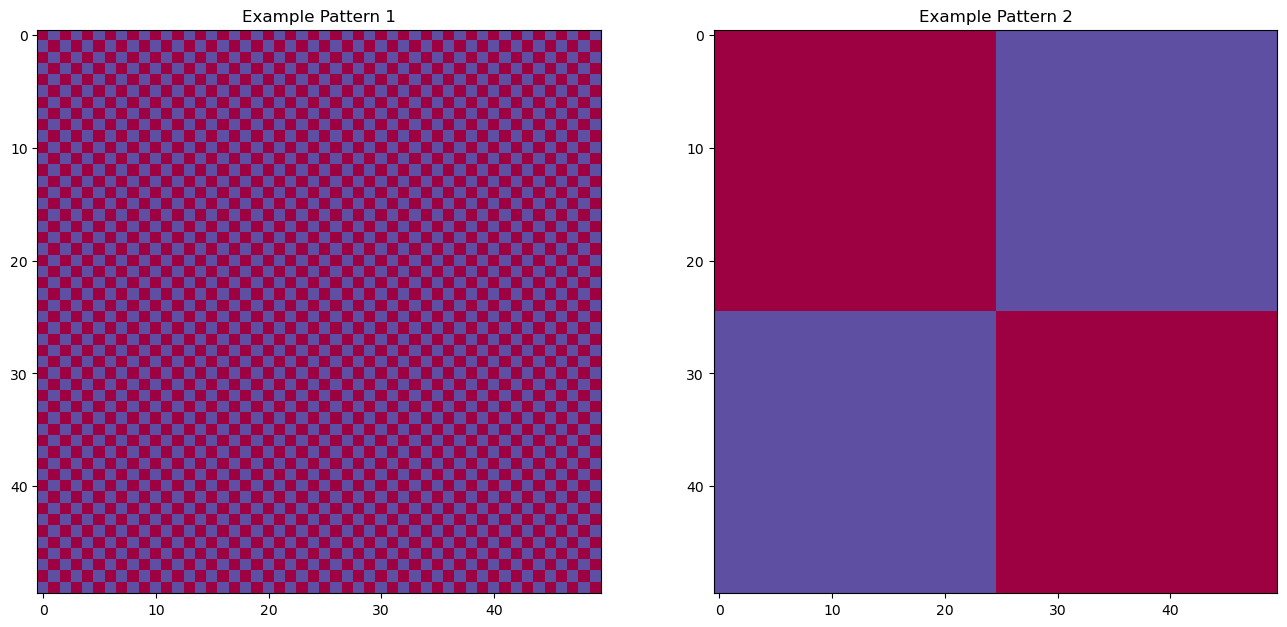

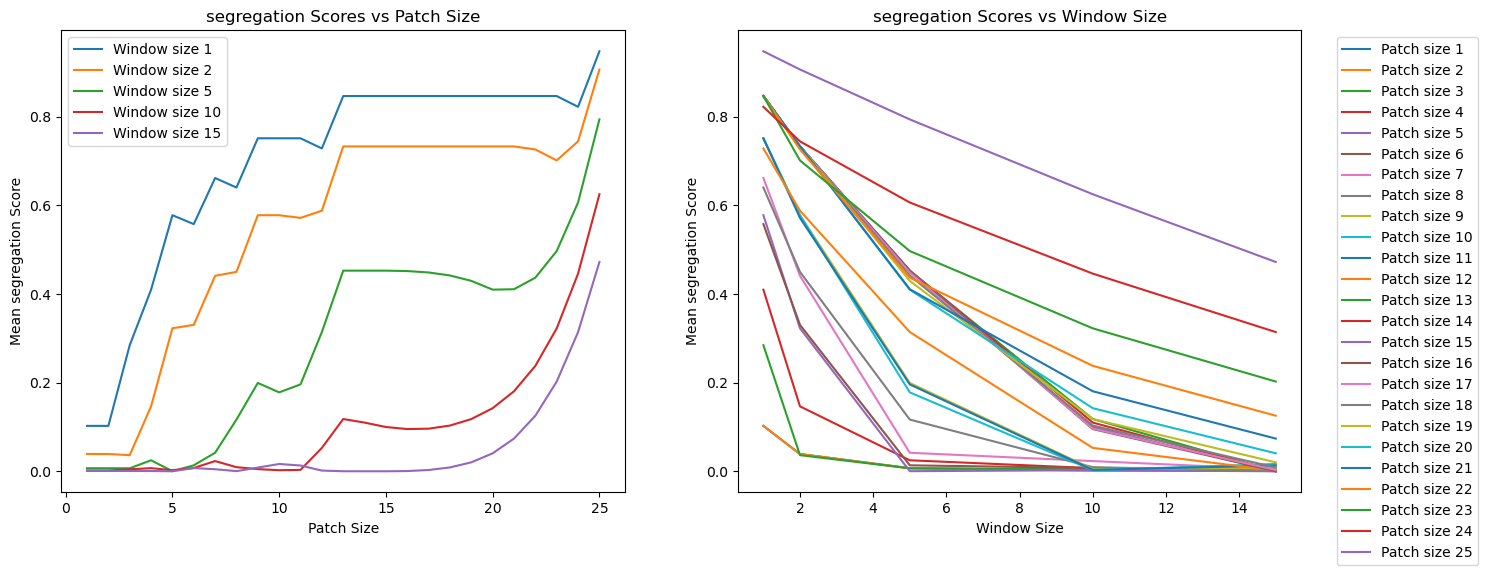

In [2]:
im1 = _create_chessboard(50, 50, 1)
im2 = _create_chessboard(50, 50, 25)

# Plot example patterns with the two extreme patch sizes
fig, ax = plt.subplots(figsize=(16,8),ncols=2)
ax[0].imshow(im1, cmap=cmap)
ax[0].set_title('Example Pattern 1')
ax[1].imshow(im2, cmap=cmap)
ax[1].set_title('Example Pattern 2')

# run segregation analysis over range of patch sizes and window sizes
window_sizes = [1,2,5,10,15] 
patch_size = np.arange(1,26,1)

segregation_results = []
for p in patch_size:
    im = _create_chessboard(50, 50, p)
    mean_segregation, std_segregation = calc_segregation_scores(im, window_sizes)
    segregation_results.append(mean_segregation)
segregation_results = np.array(segregation_results)

# Plot segregation results
fig, axs =  plt.subplots(1, 2, figsize=(16,6))
for idx, w in enumerate(window_sizes):
    axs[0].plot(patch_size, segregation_results[:,idx], label=f'Window size {w}')
axs[0].set_xlabel('Patch Size')
axs[0].set_ylabel('Mean segregation Score')
axs[0].set_title('segregation Scores vs Patch Size')
axs[0].legend()

for idx, p in enumerate(patch_size):
    axs[1].plot(window_sizes, segregation_results[idx,:], label=f'Patch size {p}')
axs[1].set_xlabel('Window Size')
axs[1].set_ylabel('Mean segregation Score')
axs[1].set_title('segregation Scores vs Window Size')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Point based measure

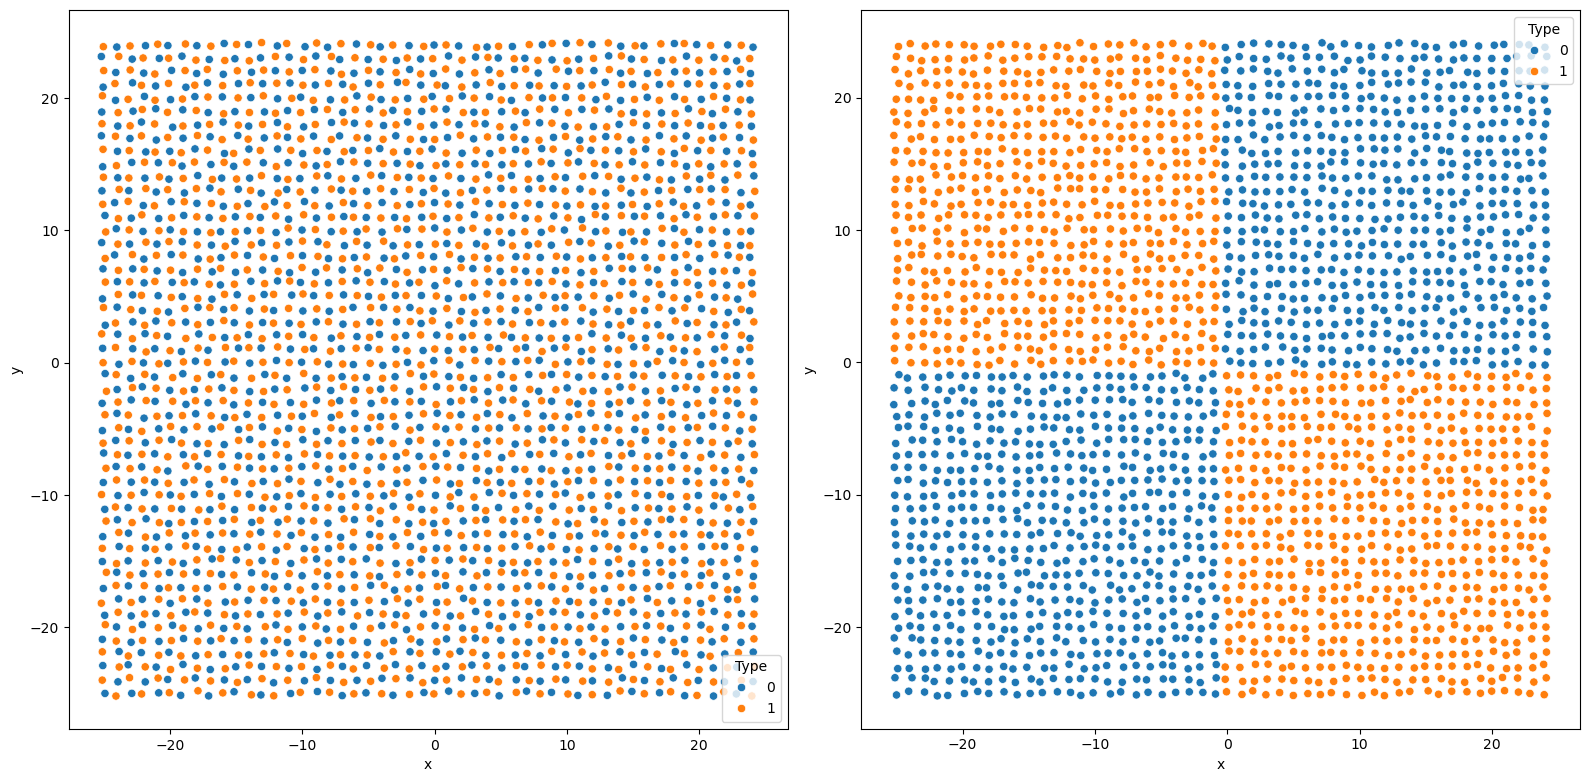

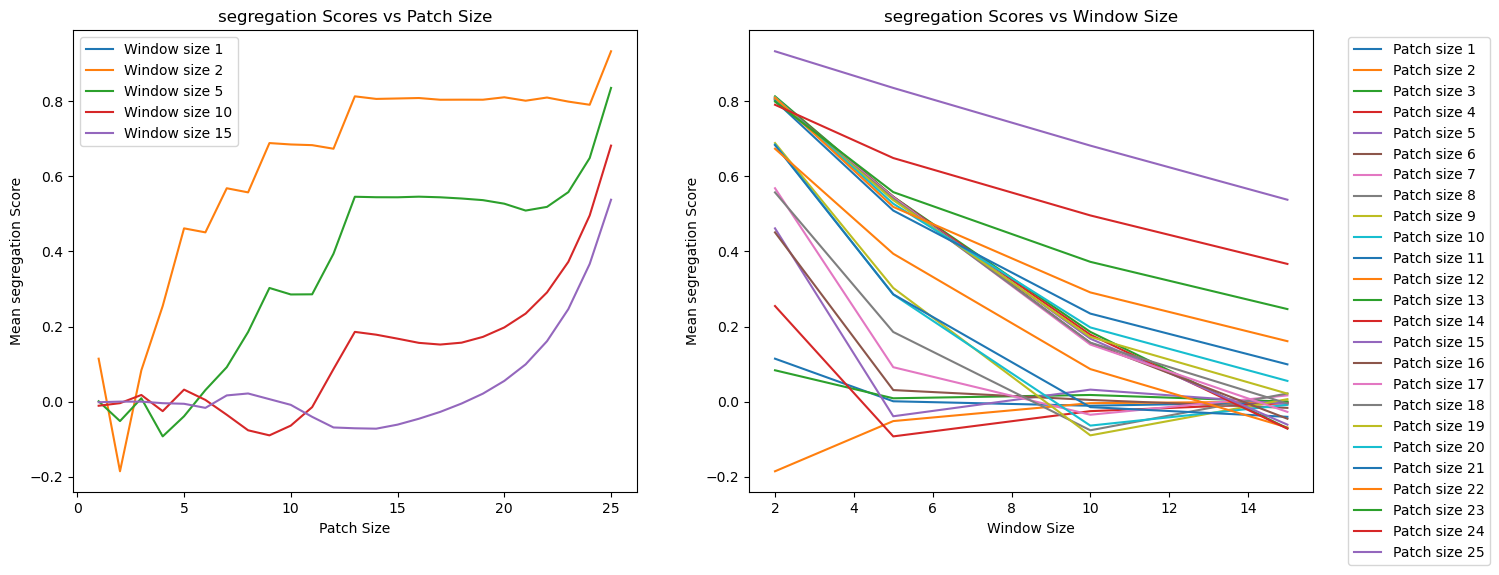

In [21]:
# Test point-based version
df1 = _create_chessboard_points(50, 50, 1, noise=0.4)
df2 = _create_chessboard_points(50, 50, 25, noise=0.4)

# Plot comparison of array-based vs point-based patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 16))

sns.scatterplot(df1, x='x', y='y', ax=axes[0], hue='Type')
axes[0].set_aspect('equal')
sns.scatterplot(df2, x='x', y='y', ax=axes[1], hue='Type')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()


# run segregation analysis over range of patch sizes and window sizes
window_sizes = [1,2,5,10,15] 
patch_size = np.arange(1,26,1)

segregation_results = []
for p in patch_size:
    im = _create_chessboard_points(50, 50, p, noise=0.4)
    mean_segregation, std_segregation = calc_segregation_scores_points(im, window_sizes, focal_type=1, other_type=0)
    segregation_results.append(mean_segregation)
segregation_results = np.array(segregation_results)

# Plot segregation results
fig, axs =  plt.subplots(1, 2, figsize=(16,6))
for idx, w in enumerate(window_sizes):
    axs[0].plot(patch_size, segregation_results[:,idx], label=f'Window size {w}')
axs[0].set_xlabel('Patch Size')
axs[0].set_ylabel('Mean segregation Score')
axs[0].set_title('segregation Scores vs Patch Size')
axs[0].legend()

for idx, p in enumerate(patch_size):
    axs[1].plot(window_sizes, segregation_results[idx,:], label=f'Patch size {p}')
axs[1].set_xlabel('Window Size')
axs[1].set_ylabel('Mean segregation Score')
axs[1].set_title('segregation Scores vs Window Size')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')